In [1]:
# izracunati fingerprints, izbaciti kojima je varijanca 0, ubaciti u model, usporediti rezultate s prijasnjima

# XGBoost regression model - 2d deskriptori, fingerprints

In [2]:
import sys
sys.path.append('../src')
from modules import *
from funkcije import calculate_fingerprint

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('../../data/solubility_all_new_data.csv', index_col=0)

In [4]:
# Pretvaranje SMILES iz DataFrame-a u listu molekula
smiles_list = data['smiles'].to_list()

# Paralelno izračunavanje otisaka molekula
with concurrent.futures.ThreadPoolExecutor() as executor:
    fps = list(executor.map(calculate_fingerprint, smiles_list))

# 'fps' sada sadrži otiske svih valjanih molekula
for fp in fps[:10]:  # Ispis prvih 10 otisaka 
    print(fp)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 1 0 ... 0 0 0]


In [5]:
# Pretvaranje liste otisaka u DataFrame
fp_df = pd.DataFrame(fps)
print(data.shape, fp_df.shape)

(3351, 7) (3351, 1024)


In [6]:
# Izračunajte varijancu za svaku kolonu
variances = fp_df.var()

# Pronađite kolone koje imaju varijancu veću od 1e-2
high_variance_cols = variances[variances > 0.01].index
print(high_variance_cols)

# Filtrirajte podatke da zadržite samo te kolone
fp_df=fp_df[high_variance_cols]

Index([   0,    1,    2,    3,    4,    5,    7,    8,    9,   10,
       ...
       1011, 1012, 1013, 1014, 1015, 1017, 1019, 1020, 1021, 1022],
      dtype='int64', length=711)


In [7]:
# Spajanje otisaka s originalnim podacima
final_data = pd.concat([data, fp_df], axis=1)

In [12]:
final_data.to_csv('../../data/solubility_features.csv')

In [8]:
train_set,test_set=train_test_split(final_data,test_size=.2,random_state=42) 
train_set.shape, test_set.shape

((2680, 718), (671, 718))

In [9]:
features = final_data.columns[3:]
target = 'Solubility'

# Podijela podataka na skupove za treniranje, validaciju i testiranje
X_train, X_test, y_train, y_test = train_test_split(final_data[features], final_data[target], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Treniranje XGBoost modela s ranom zaustavom
model = xgb.XGBRegressor(n_estimators=110, learning_rate=0.15, max_depth=8)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

# Predviđanje na testnom skupu
y_pred = model.predict(X_test)

# Izračunavanje srednjekvadratne pogreške
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Izračunavanje R2 koeficijenta determinacije
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

Mean Squared Error: 1.1230269987548909
R2 Score: 0.7531170193236357


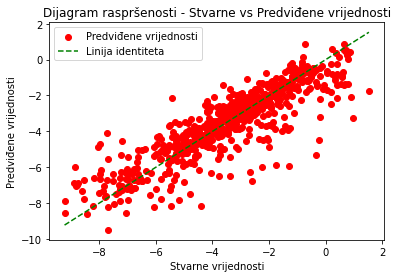

In [10]:
# Predviđanje na testnom skupu
y_pred = model.predict(X_test)

# Plotanje dijagrama raspršenosti
plt.scatter(y_test, y_pred, c='red', label='Predviđene vrijednosti')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='green', label='Linija identiteta')
plt.xlabel('Stvarne vrijednosti')
plt.ylabel('Predviđene vrijednosti')
plt.title('Dijagram raspršenosti - Stvarne vs Predviđene vrijednosti')

plt.legend()
plt.show()

In [11]:
# Definirajte raspon vrijednosti za parametre koje želite optimizirati
param_grid = {
    'n_estimators': [100, 110],
    'learning_rate': [0.05, 0.15],
    'max_depth': [5, 8]
}

# Inicijalizirajte model koji želite optimizirati
model = xgb.XGBRegressor()

# Inicijalizirajte pretraživač po rešetci s modelom i parametrima
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Izvršite pretraživanje po rešetci na podacima za treniranje
grid_search.fit(X_train, y_train)

# Ispišite najbolje kombinacije parametara
print("Najbolji parametri:", grid_search.best_params_)

# Trenirajte model s najboljim parametrima na cijelom skupu za treniranje
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Predviđanje na testnom skupu
y_pred = best_model.predict(X_test)

# Izračunavanje srednjekvadratne pogreške
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Izračunavanje R2 koeficijenta determinacije
r2 = r2_score(y_test, y_pred)
print('R2 Score:', r2)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Najbolji parametri: {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100}
Mean Squared Error: 1.15284073790364
R2 Score: 0.7465628538455915
